# Model Training

Load clean data

In [63]:
import pickle
import os
import numpy as np
import pandas as pd

In [64]:
docs_cleaned_dir = './Dataset/cleaned/final/docs/'
docs_cleaned_file = docs_cleaned_dir + 'docs_cleaned.pkl'
with open(docs_cleaned_file, 'rb') as f:
    docs_cleaned = pickle.load(f)

In [65]:
docs_dct = docs_cleaned['dct']
docs_corpus = docs_cleaned['corpus']
docs_counter = docs_cleaned['counter']
docs_docs = docs_cleaned['docs']
docs_ids = docs_cleaned['ids']
docs_key_words = docs_cleaned['key_words']

In [66]:
# documents = corpus.get_texts()
print(len(docs_corpus), " = number of docs in corpus")
print(len(docs_docs))
print(len(docs_dct.dfs))
print(len(docs_counter), " = number of words in corpus") 
print(len(docs_key_words))

4536  = number of docs in corpus
4536
156733
10953  = number of words in corpus
4569


In [67]:
sections_cleaned_dir = './Dataset/cleaned/final/sections/'
sections_cleaned_file = sections_cleaned_dir + 'sections_cleaned.pkl'
with open(sections_cleaned_file, 'rb') as f:
    sections_cleaned = pickle.load(f)

In [68]:
sections_dct = sections_cleaned['dct']
sections_corpus = sections_cleaned['corpus']
sections_counter = sections_cleaned['counter']
sections_docs = sections_cleaned['docs']
paper_ids = sections_cleaned['ids']
# sections_dct.filter_extremes(no_below=20)

In [69]:
len(sections_dct), len(sections_corpus)

(13165, 52020)

In [70]:
sections_lens = list(map(len, sections_corpus))

In [71]:
# documents = corpus.get_texts()
print(len(sections_corpus), " = number of sections in corpus")
#print(len(sections_ids))
#print(len(sections_docs))
#print(len(sections_dct.dfs))
#print(len(sections_counter), " = number of words in corpus") 
#print(len(sections_word_list), " -  word_list contains duplicates!")
print(round(np.mean(sections_lens),3), " = mean len of sections after filtering")

52020  = number of sections in corpus
114.974  = mean len of sections after filtering


In [72]:
%%time
lengths = list(map(lambda x: sum(map(lambda y: y[1],x)),sections_corpus))

Wall time: 509 ms


In [73]:
%%time
x = {(s_idx,w):f(s_idx,w,wc) for s_idx,s in enumerate(sections_cleaned['corpus']) for w,wc in s}

TypeError: '_io.BufferedReader' object is not callable

In [85]:
import collections

In [148]:
def log_weights(dct, V):
    '''
    dct: Gensim dictionary
    V: vocabulary size (int)
    '''
    
    w_max = float('-inf')
    w_min = float('+inf')
    
    ordered_dct = collections.OrderedDict(sorted(dct.cfs.items()))
    values = list(ordered_dct.values())
    #weights = [-np.log(x / dct.num_pos) for x in values]
    weights = [x / dct.num_pos for x in values]
    weights = [-np.log(w) if w > 1/V else -np.log(1/V) for w in weights ]
    weights = [(w - np.min(weights)) / (np.max(weights) - np.min(weights)) for w in weights]
    return weights

In [149]:
dct = sections_dct
V = len(dct.token2id)
weights_log = log_weights(dct, V)

(array([   20.,    24.,    31.,    76.,   135.,   205.,   265.,   360.,
          429., 11620.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

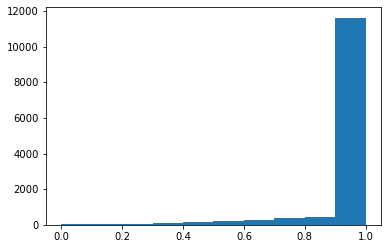

In [141]:
plt.hist(weights_log)

In [123]:
def pmi_weights(sections_cleaned):
    corpus = sections_cleaned['corpus']
    dct = sections_cleaned['dct']
    
    sections_lens = list(map(lambda x: sum(map(lambda y: y[1],x)),corpus))
    
    ordered_dct = collections.OrderedDict(sorted(dct.cfs.items()))
    values = list(ordered_dct.values())
    weights = {}
    w_max = float('-inf')
    w_min = float('+inf')
    
    for s_idx, s in enumerate(corpus):
        section_length = sections_lens[s_idx]
        
        for w, wc in s:
            weight_section = wc / section_length
    
            weight = -np.log( weight_section / (values[w] / dct.num_pos))
            weights[(s_idx,w)]  = weight
            w_max = max(w_max, weight)
            w_min = min(w_min, weight)
    
    print('normalizing')
    for key,val in weights.items():
        weights[key] = (val - w_min) / (w_max - w_min)
    
    return weights, w_max, w_min

In [124]:
weights_pmi, w_max, w_min = pmi_weights(sections_cleaned)

normalizing


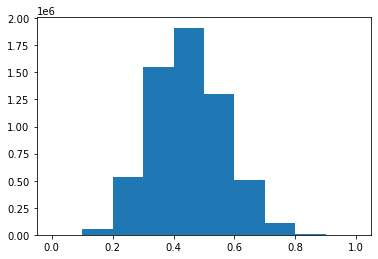

In [133]:
import matplotlib.pyplot as plt
plt.hist(b.values())
plt.show()

In [76]:
def calc_weights(docs_cleaned, sections_cleaned):
    corpus = sections_cleaned['corpus']
    dct = sections_cleaned['dct']
    paper_id = sections_cleaned['ids']
    
    corpus_doc = docs_cleaned['corpus']
    paper_ids_doc = docs_cleaned['ids']
    dct_doc = docs_cleaned['dct']
    
    sections_lens = list(map(lambda x: sum(map(lambda y: y[1],x)),corpus))
    document_lens = list(map(lambda x: sum(map(lambda y: y[1],x)),corpus_doc))
    corpus_doc_dictlist = list(map(dict, corpus_doc))
    weights = {} 
    w_max = float('-inf')
    w_min = float('+inf')
    for s_idx,s in enumerate(corpus):  
        section_length = sections_lens[s_idx]
        paper_id = paper_ids[s_idx]
        ind = paper_ids_doc.index(paper_id)
        document_length = document_lens[ind]
        for w, wc in s:
            # Calculate section-level weight
            #weight_section = (wc + 1) / (dct.cfs[w] + section_length)
            weight_section = wc / section_length
            
            # Calculate document-level weight
            w_doc = dct_doc.token2id[dct[w]] #what happens when section word isnt in doc dct?    and
            try:
                count_doc = corpus_doc_dictlist[ind][w_doc]
            except:
                count_doc = 0
            #weight_document = (count_doc + 1) / (dct_doc.cfs[w_doc] + document_length)
            weight_document = count_doc / document_length
            
            # Combined weight
            weight_combined = -np.log(weight_section/weight_document)
            #weight_combined = weight_section*weight_document
            w_max = max(w_max, weight_combined)
            w_min = min(w_min, weight_combined)
            weights[(s_idx,w)] = weight_combined

#     weights = (weights-np.min(weights)) / (np.max(weights)-np.min(weights))
    print('normalizing')
    for key,val in weights.items():
        weights[key] = (val - w_min) / (w_max - w_min)
    
    return weights, w_max, w_min
    

In [147]:
def calc_section_level_weights(docs_cleaned, sections_cleaned):
    'Calculate term weights with gensim corpus'
    
    corpus = sections_cleaned['corpus']
    dct = sections_cleaned['dct']
    paper_id = sections_cleaned['ids']
    
    corpus_doc = docs_cleaned['corpus']
    paper_ids_doc = docs_cleaned['ids']
    dct_doc = docs_cleaned['dct']
    
    weights = np.zeros((len(corpus), len(dct.cfs)), dtype=np.float16) 
    
    for d_idx,d in enumerate(corpus):
        #print(d_idx)
        for w_idx, c in enumerate(d):
            # section length
            section_length = sum([x[1] for x in d])
            print(section_length)
            break
            # Calculate section-level weight
            #weight_section = (c[1] + 1) / (dct.cfs[w_idx] + section_length)
            weight_section = c[1] / section_length
            
            # Calculate document-level weight
            paper_id = paper_ids[d_idx]
            ind = paper_ids_doc.index(paper_id)

            # document length
            document_length = sum([x[1] for x in corpus_doc[ind]])

            
            w_idx_doc = dct_doc.token2id[dct[w_idx]]

            count_doc = 0
            if w_idx_doc in dict(corpus_doc[ind]).keys():
                count_doc = dict(corpus_doc[ind])[w_idx_doc]


            #weight_document = (count_doc + 1) / (dct_doc.cfs[w_idx_doc] + document_length)
            weight_document = count_doc / document_length
            
            # Combined weight
            #weight_combined = weight_section*weight_document
            weight_combined = -np.log(weight_section/weight_document)
            
            weights[d_idx][w_idx] = weight_combined
    
    weights = (weights-np.min(weights)) / (np.max(weights)-np.min(weights))
    return weights

In [77]:
%%time
def unit_test():
    b = calc_weights(docs_cleaned, sections_cleaned)
    a = calc_section_level_weights(docs_cleaned, sections_cleaned)
    assert(a==b)
# unit_test()
b,w_max,w_min = calc_weights(docs_cleaned, sections_cleaned)

normalizing
Wall time: 20.1 s


In [25]:
weights = calc_section_level_weights(docs_cleaned, sections_cleaned)

In [81]:
# Update gensim corpus with weighted values
def update_corpus(corpus, weights, const = 100):
    for d_idx,d in enumerate(corpus):

        for w_idx, c in enumerate(d):

            corpus[d_idx][w_idx] = (c[0], float(c[1])*weights[d_idx][w_idx])*const

In [82]:
sections_corpus = update_corpus(sections_corpus, weights)

OLD TRAINING FILE BELOW THIS

In [12]:
# with open('./processed/text_df/pdf_parses_0.pkl','rb') as f:
#     text_df = pickle.load(f)

In [13]:
text_df = text_df.set_index('paper_id')
key_words = text_df.loc[ids].key_words

In [14]:
len(key_words)

493

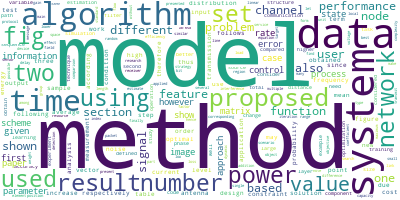

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
#long_string = ','.join(list(papers['paper_text_processed'].values))
long_string = ' '.join(word_list)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
#wordcloud.generate(long_string)
#wordcloud.generate(word_list)
wordcloud.generate_from_frequencies(counter)

# Visualize the word cloud
wordcloud.to_image()

In [102]:
corpus = sections_corpus
dct = sections_dct
docs = sections_docs
ids = paper_ids

In [86]:
# Step 4: Train the LDA model
from gensim.models import LdaModel, LdaMulticore
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric
import logging

field = 'cs-med-kw-only'
num_topics = 50
model_dir= f'./models/{field}/k_{num_topics}/'
os.makedirs(model_dir,exist_ok=True)

model_file = model_dir + 'model'
# The filename is the file that will be created with the log.
# If the file already exists, the log will continue rather than being overwritten.
log_file = model_dir + 'model_callbacks.log'
logging.basicConfig(filename=log_file,
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = docs) # very compute intensive
coherence_umass_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'u_mass')

lda_model = LdaModel(corpus=corpus,
                         id2word=dct,
                         random_state=2020,
                         num_topics=num_topics,
                         passes=100,
                         chunksize=100,
#                          batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=150,
                         gamma_threshold=0.001,
                         per_word_topics=True,
                         callbacks=[perplexity_logger,
                                    convergence_logger,
#                                     coherence_cv_logger,
                                    coherence_umass_logger])

lda_model.save(model_file)

In [87]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(49,
  '0.000*"threedimensional" + 0.000*"guessing" + 0.000*"cient" + '
  '0.000*"uncertain" + 0.000*"smmimo" + 0.000*"decouple" + 0.000*"effector" + '
  '0.000*"llrs" + 0.000*"millimeter" + 0.000*"elicit"'),
 (48,
  '0.000*"interrelation" + 0.000*"concurrency" + 0.000*"extracellular" + '
  '0.000*"find" + 0.000*"autocorrelations" + 0.000*"assurance" + '
  '0.000*"largesystem" + 0.000*"employee" + 0.000*"uploaded" + 0.000*"forced"'),
 (47,
  '0.000*"adjustment" + 0.000*"wrapper" + 0.000*"emulate" + 0.000*"pointer" + '
  '0.000*"codeword" + 0.000*"nonconstant" + 0.000*"timevariant" + '
  '0.000*"establishing" + 0.000*"happy" + 0.000*"signalprocessing"'),
 (46,
  '0.000*"therefore" + 0.000*"primaldual" + 0.000*"despite" + '
  '0.000*"buffering" + 0.000*"interpolate" + 0.000*"anonymity" + '
  '0.000*"irrelevant" + 0.000*"sup" + 0.000*"chronological" + '
  '0.000*"naturalistic"'),
 (45,
  '0.000*"sounding" + 0.000*"chaos" + 0.000*"selfattention" + '
  '0.000*"reconfigured" + 0.000*"assemb

TypeError: object of type 'NoneType' has no len()

In [95]:
def get_top_documents(corpus,ids,topic, num_topics):
    #num_topics = 5
    topic_proportions = np.zeros(shape=(len(corpus),num_topics+1))
    topic_proportions[:,0] = ids
    response = lda_model.get_document_topics(corpus)
    for i,doc in enumerate(response):
        for t,prop in doc:
            topic_proportions[i][t+1] = prop 
    ind = topic_proportions[:,topic+1].argsort()[::-1]
    return topic_proportions[ind]

In [103]:
top_docs = get_top_documents(corpus,ids,1, num_topics=50)

IndexError: index 13165 is out of bounds for axis 1 with size 13165

In [25]:
top_ids = top_docs[:15,0] 
top_ids_idx = [ids.index(str(int(i))) for i in top_ids]
key_words[top_ids_idx]

paper_id
71151637     [Lithium-ion battery,  tab design,  tab locati...
49420450     [Electro-hydraulic brake system (EHBS),  norma...
122282       [Harmonic mitigation techniques,  power qualit...
204816433    [Permanent-magnet synchronous machine (PMSM), ...
54436915     [DC/dc power conversion,  high voltage direct ...
84187192     [Stator-ironless,  brushless DC (BLDC) motor, ...
52299444     [Spherical smart aggregate (SSA),  spherical p...
49863470     [Active vibration suppression,  CSVS method,  ...
201847005    [Finite element methods,  fluid dynamics,  num...
199006398    [Flight test,  generator test,  electrical sim...
209320708    [Speckle reduction,  light pipe,  refractive o...
6465220      [Wind-wave farm,  energy storage,  power quali...
203211856    [Contact blasting,  damage mechanism,  experim...
61807643     [Switching frequency,  DC-DC converter with ac...
18223757     [Circulating current,  discontinuous space-vec...
Name: key_words, dtype: object

In [101]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts = docs, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.318927777972042


/Users/virenbajaj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/virenbajaj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/virenbajaj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/Users/virenbajaj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Nump

In [102]:
num_topics = 5

top_topics = lda_model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

# from pprint import pprint
# pprint(top_topics)

Average topic coherence: -2.2550.


In [32]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from IPython.display import display

In [33]:
prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dct)
display(pyLDAvis.display(prepared))

/Users/virenbajaj/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [3]:
with open('./processed/refs/meta_df/metadata_1.pkl', 'rb') as f:
    meta_df = pickle.load(f)

In [30]:
def get_links(refs_paper):
    refs, links = [], []
    for key,value in refs_paper.items():
        if value['link']:
            links.append(value['link'])
            refs.append(key)
    return links, refs
text_df_kw = text_df.loc[ids]
all_citations = (text_df_kw['citations'].values)
all_links=[]
all_refs=[]
for citation in all_citations:
    links,refs = get_links(citation)
    all_links.append(links)
    all_refs.append(refs)

In [31]:
flat_links = [item for sublist in all_links for item in sublist]
links_found = set(flat_links).intersection(set(meta_df.ids))

len(links_found), len(flat_links)

(101, 13963)

In [32]:
len(text_df)

147355